# Robust Angular Diameters in Python (`RADPy`)

## Introduction to `RADPy`

`RADPy` stands for Robust Angular Diameters in Python. This was created to allow for multi-wavelength fits for angular diameters of stars measured with interferometric methods. Currently `RADPy` only has compatibility with the instruments on the Center for High Angular Resolution Astronomy (CHARA) Array. `RADPy` is currently configured for the following instruments at CHARA:

- Classic/CLIMB
- PAVO
- VEGA
- MIRC-X (in progress)

The remaining CHARA instruments SPICA and MYSTIC will be integrated soon.

## What does `RADPy` actually do?
`RADPy` accepts data from an arbitrary number of beam-combiners from CHARA and allows the user to fit for the angular diameters (both uniform disk and limb-darkened disk) of single stars. With the fitted angular diameter, the user can also calculate the remaining fundamental stellar parameters of effective temperature, stellar luminosity, and radius of the measured star. The user can also plot the interferometric data with the chosen angular diameter fit (uniform or limb-darkened) which will output a publication ready plot. The plotting is highly customizable to the user's needs, including the type of model plotted, the ability to add the diameter in text to said plot, the binning of the data if the user choses to, and more. 

The core of `RADPy` is a Monte Carlo simulation that involves a custom-built bracket bootstrapping within. A bracket in the realm of interferometry describes a set of data taken at the same time. Several instruments at CHARA span a wavelength range, so for every one observation, there is a span of data points to cover the wavelength ranges. `RADPy` automatically assigns a bracket number to the data once the data files are read in. The bracket numbers are assigned based on time-stamp and for PAVO, based on the same UCOORD and VCOORD measurements (as PAVO data does not output a time stamp). 

For uniform disk diameters, `RADPy` will sample the wavelength of observations on a normal distribution. Within the bracket bootstrapping, the visibilities of each bracket chosen to be fit are sampled on a normal distribution. Using lmfit, the data are then fit using the uniform disk visibility squared equation. The final output results in a list of angular diameters calculated. The final uniform disk diameter is determined by taking the average of the uniform disk diameters and the error is determined by taking the mean absolute deviation. 

For limb-darkened disk diameters, `RADPy` follows a similar structure to the uniform disk diameters. There are a few differences which I'll highlight below:

- One needs the limb-darkening coefficient. To account for the limb-darkening coefficient, the tables of limb-darkening coefficients determined by Claret et al. 2011 are used. Based on the observation band, surface gravity (log g), and the effective temperature (Teff) of the star, `RADPy` will use an interpolated function based on the Claret tables to calculate the limb-darkening coefficient. If the effective temperature is less than 3500 and the surface gravity is between 3.5 and 5, the tables with the PHOENIX models are used. For all other stars, the tables with the ATLAS models are used.
- For each iteration of the MC, `RADPy` calculates a limb-darkening coefficient for each band used (i.e. R-band). Within the bootstrapping, `RADPy` samples the limb-darkening coefficient on a normal distribution using 0.02 has the "error". The limb-darkening coefficient is then used in the full visibility squared equation and the limb-darkened angular diameter is fit.
- To ensure `RADPy` is fitting for the optimal angular diameter, the limb-darkened disk fitting function will iterate until minimal change between the previous angular diameter and the one just calculated is seen. For robustness, the effective temperature is also checked as well. Minimal change is defined as being less than or equal to 0.05% difference.

## What is in this notebook?

This tutorial is designed to show the general steps of how a user should implement `RADPy` for your own angular diameter fitting needs. This notebook will go over how to install, how to import the necessary modules from `RADPy`, how to read in your data, how to perform initial fits, how to run the Monte Carlo simulations, how to calculate the remaining stellar parameters, and how to generate publicaiton ready plots. 

## Usage

If you do use this package, please use the following citation:

## Contact
- Ashley Elliott (aelli76@lsu.edu)

## Resources
Link to the github repository (currently private but will be made public soon once documentation is finished): <https://github.com/spaceashley/radpy>


## To install:

**Please pay careful attention to this!!**

Simply use pip to install `RADPy`. Due to naming conflicts, to install `RADPy`, you must use "rsadpy". 

`pip install rsadpy`

The installation should also install all necessary additional packages you need to run everything. Just in case, here is a list of all the necessary packages that aren't default:
- `lmfit`
- `astropy`
- `astroquery`
- `gaiadr3-zeropoint`

To test if the installation worked, import `RADPy`. If you did not get an error, you should be all set. 

`import radpy`

NOTE: 

to _install_, use rsadpy. **Note the 's'**

to _import_, use radpy. **Note that there is no longer an s**

In [ ]:
#pip install rsadpy

In [ ]:
#import radpy

## Step 1: Getting the data set-up for use
Now that you've installed `RADPy`, first step is to read in your data files.

`RADPy` accepts .txt, .fits, .csv, and .oifits.

Your first step is to import all modules from `radpy.datareadandformat` using the "*". 


In [1]:
from radpy.datareadandformat import *

Next step is to set your file path. In the example below, I'm setting the file path for three different instruments.

In [2]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\radpy\\data\\Vegadata.csv"

Next, we want to use the function `filename_extension()`. 
The two inputs will be your filepath you just set above and then an indicator for which instrument the data are from. 
Here are the list of acceptable indicators:
- 'C' for Classic.
- 'V' for VEGA
- 'P' for PAVO
- 'M' for MIRC-X
- 'My' for MYSTIC
- 'S' for SPICA

In [3]:
datav, num_brack_v = filename_extension(filenamev, 'V')
datac, num_brack_c = filename_extension(filenamec, 'C')
datap, num_brack_p = filename_extension(filenamep, 'P')

Number of brackets: 20
Number of brackets: 1
Number of brackets: 17


Our next step is to convert the data into an `InterferometryData` object. This object will allow for ease of use through the fitting. 
There is an object name for each instrument (so far). 

Below is the syntax:

PAVO - `PavoData(data)`

VEGA - `VegaData(data)`

Classic - `ClassicData(data)`

MIRCX - `MircxData(data)`

The "data" will be the output of the `filename_extension` function you called in the previous step. 


In [4]:
pavo_data = PavoData(datap)
vega_data = VegaData(datav)
classic_data = ClassicData(datac)

The last step to complete for getting the data ready to use is to combine all your data into one. RADPy is a combined fit so we need to of course combine the data. To do this, use the function `combined()`. 

The inputs for this function will be the data you would like to combine. So for the purposes of this tutorial, we are combining three data sets, PAVO, VEGA, and Classic. One key step here is to use the `InterferometryDataObject`'s attribute `make_df()`. This will convert your data into a pandas dataframe for use.


In [5]:
b, v2, dv2, wave, band, brack, inst = combined(pavo_data.make_df(), classic_data.make_df(), vega_data.make_df())
spf = b/wave

In [ ]:
print(max(spf))
print(max(spf)*1.1)

In the above cell, **combined** will return the baseline, visibility squared, error on the visibility squared, the wavelength of each measurement, the bandwidth for each measurement, the bracket assigned to each measurement, and the instrument each data point is associated with. 

We also calculate the spatial frequency for use later (mainly for plotting) by dividing the baseline by the wavelength. 

## Step 2: Creating a Stellar Params object
Aside from the data, the only other information needed for the fits to run are additional stellar parameters for your target. 

You need the following:
| Parameter        | Unit          |
| ------------- |:-------------:| 
| Bolometric Flux     | 10^-8 ergs/s/cm^2  |
| Error on Bolometric Flux     | 10^-8 ergs/s/cm^2     |
| [Fe/H] | dex      |
| Error on [Fe/H] | dex |
| Surface gravity (log g) | dex |
|Error on surface gravity (log g) | dex |

`RADPy` has a class named `StellarParams()`. This class will store all of your stellar parameters throughout the notebook. 

To create a `StellarParams()` object, first we need to import: 

`from radpy.stellar import *`


In [6]:
from radpy.stellar import *

To create the object, simply call the object: `StellarParams()`. 

In [7]:
star = StellarParams()

We have now created a `StellarParams()` object. To see the contents of the object, just type out the name you called it. For this tutorial, I've named it `star`. You should be able to see all the parameters it has as a default, then there should be a `None` and then the associated unit with each variable. The `None` is there because we have yet to fill the object with any parameters. 

In [ ]:
star

Alright, lets add some parameters. 

To add parameters to your `StellarParams()` object, the syntax is: "object name"."parameter name". 

Here is a table of all the built-in stellar parameters a `StellarParams()` object has, their units, and how to access them (if your `StellarParams()` object is called `star`):

| Parameter                                 | Unit                  | Example Syntax                |
|-------------------------------------------|:---------------------:|-------------------------------|
| Bolometric Flux                           | 10^-8 ergs/s/cm^2     | `star.fbol`             |
| Bolometric Flux error                     | 10^-8 ergs/s/cm^2     | `star.fbol_err`         |
| Log surface gravity                       | dex                   | `star.logg`             |
| Log surface gravity error                 | dex                   |`star.logg_err`          |
| Metallicity                               | dex                   | `star.feh`              |
| Metallicity error                         | dex                   | `star.feh_err`          |
| Parallax                                  | milliarcseconds (mas) | `star.plx`              |
| Parallax error                            | milliarcseconds (mas) | `star.plx_err`          |
| Distance                                  | parsecs (pc)          | `star.dist`             |
| Distance error                            | parsecs (pc)          | `star.dist_err`         |
| Initial uniform disk diameter             | milliarcseconds (mas) | `star.udthetai`         |
| Initial uniform disk diameter error       | milliarcseconds (mas) | `star.udthetai_err`     |
| Initial limb-darkened disk diameter       | milliarcseconds (mas) | `star.ldthetai`         |
| Initial limb-darkened disk diameter error | milliarcseconds (mas) | `star.ldthetai_err`     |
| Final uniform disk diameter               | milliarcseconds (mas) | `star.udtheta`          |
| Final uniform disk diameter error         | milliarcseconds (mas) | `star.udtheta_err`      |
| Final limb-darkened disk diameter         | milliarcseconds (mas) | `star.ldtheta`          |
| Final limb-darkened disk diameter error   | milliarcseconds (mas) | `star.ldtheta_err`      |
| Effective temperature                     | Kelvin (K)            | `star.teff`             |
| Effective temeprature error               | Kelvin (K)            | `star.teff_err`         |
| Stellar luminosity                        | L☉                   | `star.lum`              |
| Stellar luminosity error                  | L☉                   | `star.lum_err`          |
| Stellar radius                            | R☉                   | `star.rad`              |
| Stellar radius error                      | R☉                   | `star.rad_err`          |
| Limb-darkening coefficient in R           |                       | `star.ldc_R`            |
| Limb-darkening coefficient in K           |                       | `star.ldc_K`            |
| Limb-darkening coefficient in H           |                       | `star.ldc_H`            |
| Limb-darkening coefficient in J           |                       | `star.ldc_J`            |


Lets go ahead and add my stellar parameters. 

In [8]:
#Stellar parameters
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

Great! Let's take a look at the object to make sure that it worked. 

In [ ]:
star

Next step is to calculate the distance. To do this, we call the `distances` function. This function will calculate the distance of your star using the parallax that you provided, or if no parallax is provided, will get the parallax for you using Gaia or Hipparcos. If you use Gaia, RADPy will apply the zero-point correction to your parallax, as described in <insert paper here>. If you use Hipparcos, no zero-point correction will be applied. The default is to use Gaia.

The inputs for `distances()` are:
| Parameter          | What is it                                                 | Example Syntax             |
|--------------------|:----------------------------------------------------------:|----------------------------|
| `star_name`        | the name of your star as a string                          | `HD 219134`                | 
| `plx`              | Optional: the parallax of your star in mas                 | `plx = 142.5`              |
|                    | Default is set to `None `                                  |                            |
| `dplx`             | Optional: the parallax error in mas                        | `dplx = 0.5`               |
|                    | Default is set to `None `                                  |                            |
| `use_Hipp`         | Optional: set to `True` if you want to use Hipparcos       | `use_Hipp = True`          |
|                    | Default is set to `False`                                  |                            |
| `verbose`          | default is `False`.                                        | `verbose = True`           |

Here are some example usages of the `distances` function for a variety of scenarios:

Have your own parallax and it came from Gaia?: `D, dD = distances('object ID', plx = p, dplx = dp)`

Have your own parallax and it came from Hipparcos?: `D, dD = distances('object ID', plx = p, dplx = dp, use_Hipp = True)`

Don't have your own parallax and you want to use Gaia?: `D, dD = distances('object ID')`

Don't have your own parallax and you want to use Hipparcos?: `D, dD = distances('object ID', use_Hipp = True)`

If you would like to see where RADPy is getting your parallax from, set "verbose" = True. This will print out where it found the parallax. It will also print out the zero-point corrected parallax and the calculated distance. 

NOTE: A warning may appear saying something similar to "UserWarning: The apparent magnitude of one or more of the sources is outside the expected range      (6-21 mag)." This is fine. This is an error from `gaiadr3-zeropoint`. If your star is outside the Gaia magnitude range (stars brighter than Gmag = 3),    use Hipparcos. 



In [9]:
D, dD = distances('HD 219134', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3: Gaia DR3 2009481748875806976
Source ID 2009481748875806976
Corrected parallax: 152.84
Distance: 6.54286 +/- 0.00212 [pc]


C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


In [ ]:
star

## Step 3: Initial fits

Now we have our stellar parameters set up and our data read in and formatted like needed. Now lets start our fits. 

The first step for the fitting is to perform an initial fit for the uniform disk diameter and then for the limb-darkened disk diameter. 

We need to first import: 

`from radpy.UDfitting import initial_UDfit`

`from radpy.LDfitting import initial_LDfit`

Next, we can run the initial uniform disk diameter fit using the function `initial_UDfit()`. 

The inputs to `initial_UDfit()` include:

| Parameter          | What is it                                                 | Example Syntax             |
|--------------------|:----------------------------------------------------------:|----------------------------|
| `spf`              | the spatial frequencies of your data                       | `spf`                      | 
| `v2`               | the visibility squared values of your data                 | `v2`                       |
| `dv2`              | error on the visibility squared values                     | `dv2`                      |
| `initial_guess`    | an initial guess on your diameter                          | `initial_guess = 0.4`      |
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`    |
| `verbose`          | default is `False`.                                        | `verbose = True`           |
|                    | If set to `True` will print our the results from `lmfit`   |                            |

In [10]:
from radpy.LDfitting import initial_LDfit
from radpy.UDfitting import initial_UDfit

In [11]:
theta1, dtheta1, chisqr1 = initial_UDfit(spf, v2, dv2, 0.4, star, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(UDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 461
    # variables        = 1
    chi-square         = 583.593270
    reduced chi-square = 1.26868102
    Akaike info crit   = 110.706678
    Bayesian info crit = 114.840076
    R-squared          = -60.2680353
[[Variables]]
    theta:  1.03756289 +/- 0.00128204 (0.12%) (init = 0.4)


Next, our limb-darkened disk initial fit, using `initial_LDfit()`.

The inputs for `initial_LDfit()` are:

| Parameter          | What is it                                                 | Example Syntax             |
|--------------------|:----------------------------------------------------------:|----------------------------|
| `spf`              | the spatial frequencies of your data                       | `spf`                      | 
| `v2`               | the visibility squared values of your data                 | `v2`                       |
| `dv2`              | error on the visibility squared values                     | `dv2`                      |
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`    |
|`filt`              | The filter in which you want to perform the initial fit in | `filt = 'R'`               |
|                    | Options include: `'R'`, `'K'`, `'H'`, and `'J'`            |                            |
| `verbose`          | default is `False`.                                        | `verbose = True`           |
|                    | If set to `True` will print our the results from `lmfit`   |                            |

In [12]:
theta2, dtheta2, chisqr2 = initial_LDfit(spf, v2, dv2, star, 'R', verbose = True)

Effective temperature: 4963.232392396183 +/- 33.51205790769525 K
LDC for filter  R : 0.6672020537173402
Initial fit with lmfit:
[[Model]]
    Model(V2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 461
    # variables        = 1
    chi-square         = 578.043019
    reduced chi-square = 1.25661526
    Akaike info crit   = 106.301366
    Bayesian info crit = 110.434764
    R-squared          = -59.6853470
[[Variables]]
    theta:  1.11365607 +/- 0.00140433 (0.13%) (init = 1.03756)


Both `initial_UDfit()` and `initial_LDfit()` automatically update the `StellarParams()` object with the initial results. 

In [ ]:
star

## Step 4: Running the fits

Now that we have the initial fits done, we can now start the Monte Carlo simulations.

First step is the uniform disk diameter fit. 

We need to first import the functions: `from radpy.UDfitting import run_UDfit, udfit_values`

To call the Monte Carlo function, we use `run_UDfit()`. 

The inputs to this function include:

| Parameter          | What is it                                                 | Example Syntax                          |
|--------------------|:----------------------------------------------------------:|-----------------------------------------|
| `mc_num`           | the number of Monte Carlo iterations                       | `mc_num = 10`                           | 
| `bs_num`           | the number of bootstrap iterations                         | `bs_num = 10`                           |
| `datasets`          | the data sets you would like to fit                       | `datasets = [data1, data2, data3]`      | 
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`                 |
| `verbose`          | default is `False`.                                        | `verbose = True`                        |
|                    | If set to `True` will print out your stellar parameters    |                                         |

This function will return a list of uniform disk diameters. 

NOTE: mc_num describes the number of outside loop iterations. bs_num will set the inner loop iterations. This means that if you set mc_num = 5, and bs_num = 5, you will have 5 iterations of the bracket bootstrapping for every one iteration of the mc_num, making it 25 iterations in total. For publication quality results, I recommend minimum mc_num = 71 and bs_num = 71, for 5041 iterations in total. 

In [13]:
from radpy.UDfitting import run_UDfit, udfit_values

In [14]:
results = run_UDfit(10, 10, datasets = [pavo_data, vega_data, classic_data], stellar_params = star)

Next, we need to calculate the uniform disk diameter and its error, along with the effective temperature. To do this, we use `udfit_values()`. This function will return the averaged uniform disk diameter, the error on said diameter, the chi-squared value of the fit, the chi-squared reduced value of the fit, and the effective temperature calculated using the diameter you just determined. 

The inputs to `udfit_values()`:

| Parameter          | What is it                                                 | Example Syntax             |
|--------------------|:----------------------------------------------------------:|----------------------------|
| `spf`              | the spatial frequencies of your data                       | `spf`                      | 
| `v2`               | the visibility squared values of your data                 | `v2`                       |
| `dv2`              | error on the visibility squared values                     | `dv2`                      |
|`results`           | results of `run_UDfit()`                                   | `results`                  | 
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`    |
| `verbose`          | default is `False`.                                        | `verbose = True`           |
|                    | If set to `True` will print out your stellar parameters    |                            |


This function will also automatically update your `StellarParams()` object with the uniform disk angular diameter and error calculated as well as with the effective temperature. 

In [15]:
udfit_values(spf, v2, dv2, results, stellar_params = star, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0384 +/- 0.0052 mas
Chi-squared: 21.241917569393028
Chi-squared reduced: 0.04617808167259354
Temperature: 4961.3 +/- 35.6 K


In [ ]:
star

Now time for the limb-darkened disk fit.

We need to first import the functions: `from radpy.LDfitting import run_LDfit`

To call the Monte Carlo function, we use `run_LDfit()`. 

The inputs to this function include:

| Parameter          | What is it                                                 | Example Syntax                          |
|--------------------|:----------------------------------------------------------:|-----------------------------------------|
| `mc_num`           | the number of Monte Carlo iterations                       | `mc_num = 10`                           | 
| `bs_num`           | the number of bootstrap iterations                         | `bs_num = 10`                           |
| `ogdata`           | the original data sets you have                            | `ogdata = [ogdata1, ogdata2, ogdata3]`  |
|                    | needs to match the data sets you have in `datasets`        |                                         | 
|`datasets`          | the data sets you would like to fit                        | `datasets = [data1, data2, data3]`      | 
|                    | needs to match the data sets you have in `ogdata`          |                                         |  
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`                 |
| `verbose`          | default is `False`.                                        | `verbose = True`                        |
|                    | If set to `True` will print out your stellar parameters    |                                   |

This function will return the final limb-darkened angular diameter and its error, the final effective temeperature and its error, the limb-darkening coefficients for each band and the chi-squared values. The verbose print statement will display how many iterations it took to find minimal changes, the limb-darkened disk diameter and its error, the limb-darkening coefficients for each wavelength, the chi square value for each LDC, te chi square reduced value for each LDC, the effective temperature and its error, and the percent differences for the last iterations. 

This function will also automatically update the `StellarParams()` object with your final values. 

NOTE: mc_num describes the number of outside loop iterations. bs_num will set the inner loop iterations. This means that if you set mc_num = 5, and bs_num = 5, you will have 5 iterations of the bracket bootstrapping for every one iteration of the mc_num, making it 25 iterations in total. For publication quality results, I recommend minimum mc_num = 71 and bs_num = 71, for 5041 iterations in total. 

NOTE: The larger the numbers for mc_num and bs_num, the longer the fit will take. It should hopefully not take longer than 5-10 minutes.

In [16]:
from radpy.LDfitting import run_LDfit

In [17]:
thetaf, dthetaf, tf, dtf, ldcsf, chisf = run_LDfit(2, 2, ogdata = [spf, v2, dv2], datasets = [pavo_data, vega_data, classic_data], stellar_params = star, verbose = True)

Final Values after  6  iterations:
Limb-darkened Disk Diameter after MC/BS: 1.1093 +/- 0.01009 mas
Limb-darkening coefficient in R: 0.68346
Chi-squared for R band: 603.307
Reduced chi-squared for R band: 1.312
Limb-darkening coefficient in K: 0.32176
Chi-squared for K band: 1390.759
Reduced chi-squared for K band: 3.023
Temperature: 4800.1 +/- 39.0 K
Percent difference: 0.0 %
Percent difference: 0.01 %


In [ ]:
star

## Step 5: Remaining Stellar Parameters

After we calculate the limb-darkened disk angular diameter and effective temperature, we can now calculate the radius of the star and the luminosity using the function `calc_star_params()`.

The inputs are:

| Parameter          | What is it                                                 | Example Syntax                    |
|--------------------|:----------------------------------------------------------:|-----------------------------------|
| `stellar_params`   | Your `StellarParams()` object                              | `stellar_params = star`           |
| `verbose`          | default is `False`.                                        | `verbose = True`                  |
|                    | If set to `True` will print out your stellar parameters    |                                   |

This function will also automatically update your `StellarParams()` object with the parameters. 

In [18]:
calc_star_params(star, verbose = True)

Linear Radius:  0.782 +/- 0.007 [R_solar]
Luminosity:  0.291 +/- 0.008 [L_solar]
Effective temperature:  4800.125 +/- 38.965 [K]


In [ ]:
star

## Step 6: Plotting your data and the fit

To plot the data and your fit(s), we will use the function `plot_vs_fit()`. This function allows the user to customize the plot to their liking. 

First we need to import the module: `from radpy.plotting import plot_v2_fit`

We then need to created a dictionary of the data you would like to plot. This is just to make it easier for the function to plot the different datasets separately, with their own markers, colors, and labels. 

`data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}`

The inputs to `plot_v2_fit()` are:

| Parameter          | What is it                                                                 | Example Syntax                                             |
|--------------------|:-----------------------------------------------------------------------------:|------------------------------------------------------------|
| `data_dict`        | Dictionary containing all your data                                        | `data_dict = {'pavo':pavo_data, 'vega':vega_data}`         |
| `star`             | Your `StellarParams()` object                                              | `star = star`                                              |
| `line_spf`         | The range of spatial frequencies you want your model to span              | `line_spf = np.linspace(0.00001, 2.5e8, 1000)`             |
|                    | *(Do not start with 0; it will return an error)*                          |                                                            |
| `set_axis`         | Sets your plot axis ranges                                                 | `set_axis = [xmin, xmax, ymin, ymax]`                     |
| `ldc_band`         | The band for your LD model                                                 | Options: `'ldc_R'`, `'ldc_K'`, `'ldc_H'`, `'ldc_J'`        |
|                    | *(If plotting UD, do not set anything)*                                   |                                                            |
| `datasets_to_plot` | The datasets you specifically want plotted                                 | `datasets_to_plot = ['pavo', 'vega', 'classic']`          |
| `plot_udmodel`     | If set to `True`, will plot the UD fit                                     | `plot_udmodel = True`                                     |
| `plot_ldmodel`     | If set to `True`, will plot the LD fit with the respective band            | `plot_ldmodel = True`                                     |
| `to_bin`           | Indicate which dataset(s) you want binned                                  | `to_bin = ['pavo']`                                       |
| `eq_text`          | If set to `True`, will annotate the angular diameter of your fit           | `eq_text = True`                                          |
| `savefig`          | Allows you to save your figure                                              | `savefig = 'starnameV2fit.jpg'`                           |
| `showfig`          | Displays the figure to your screen (default is `True`)                     | `showfig = True`                                          |


In [ ]:
from radpy.plotting import plot_v2_fit

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from radpy.UDfitting import UDV2
from radpy.LDfitting import V2
plt.rcParams['text.usetex'] = True


# Function to bin the PAVO data
def bin_data(x, y, dy, bin_width=5e6, min_points_per_bin=1):
    ###########################################################################
    # Function: bin_data                                                      #
    # Inputs: x -> the x data to bin                                          #
    #         y -> the y data to bin                                          #
    #         bin_width -> the width of the data bins                         #
    #                      default is 5e6 but can be changed                  #
    #         min_points_per_bin-> ensures every bin has 1 data point in it   #
    #                              to avoid nans and issues                   #
    # Outputs: binned_x, binned_y, and binned_dy                              #
    # What it does:                                                           #
    #       1. ensures the input data are arrays                              #
    #       2. sorts the data to make sure its binning properly               #
    #       3. determines the number of bins needed for the data              #
    #       4. sets the bin indices                                           #
    #       5. goes through the data and assigns the data into a bin          #
    #       6. takes the weighted average of the values in each bin           #
    #       7. appends the weighted average into a list                       #
    #       8. Returns the weighted average of each bin                       #
    ###########################################################################

    # Ensure input is numpy array
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    # Sort by x
    order = np.argsort(x)
    x, y, dy = x[order], y[order], dy[order]

    min_x = x.min()
    max_x = x.max()
    num_bins = max(1, int(np.ceil((max_x - min_x) / bin_width)))
    if num_bins < 1:
        num_bins = 1

    bins = np.linspace(min_x, max_x, num_bins + 1)
    inds = np.digitize(x, bins, right=True)

    avg_x = []
    avg_y = []
    avg_dy = []
    for i in range(1, len(bins)):
        mask = inds == i
        if np.any(mask) and np.sum(mask) >= min_points_per_bin:
            weights = 1 / dy[mask] ** 2
            # weighted mean for x and y
            wx = np.average(x[mask], weights=weights)
            wy = np.average(y[mask], weights=weights)
            wdy = 1 / np.sqrt(np.sum(weights))
            avg_x.append(wx)
            avg_y.append(wy)
            avg_dy.append(wdy)
    return np.array(avg_x), np.array(avg_y), np.array(avg_dy)

##########################################################################################
def plot_v2_fit(data_dict, star, line_spf = None, ldc_band=None, eq_text=False,
                datasets_to_plot=None, plot_ldmodel=False, plot_udmodel=False,
                to_bin=None, title = None, savefig=None, show=True):
    ###########################################################################
    # Function: plot_v2_fit                                                   #
    # Inputs: data_dict -> dict of InterferometryData objects,                #
    #                    e.g. {'pavo': pavo_obj, ...}                         #
    #         star-> star object with .theta and .ldc* attributes             #
    #                (ldcR, ldcK, etc.), and .V2(line_spf, theta, ldc)        #
    #         line_spf -> x values for model curve                            #
    #         set_axis -> set the axis limits e.g. [xmin, xmax, ymin, ymax]   #
    #         ldc_band -> string (e.g. "ldcR", "ldcK") for which LDC          #
    #                     coefficient to use                                  #
    #         eq_text -> optional string for annotation                       #
    #         datasets_to_plot-> list of keys in data_dict to plot            #
    #                            (default: all)                               #
    #         plot_ldmodel-> bool, whether to plot the ld model curve         #
    #         plot_udmodel -> bool, whether to plot the ud model curve        #
    #         to_bin -> list of kets in data_dict to bin                      #
    #         interact -> sets matplotlib ipympl, default is False            #
    #         savefig-> filename to save, if desired                          #
    #         show-> whether to plt.show()                                    #
    # Outputs: the plot                                                       #
    # What it does:                                                           #
    #        1. Initializes plotting parameters                               #
    #        2. Checks to see what datasets the user wants plotted            #
    #        3. Defines dictionaries for each instrument and the marker,      #
    #           color, label, and alpha value for each one                    #
    #        Starts with the top plot                                         #
    #        4. for each data set, sets the keys for the color, marker, label #
    #           and alpha value                                               #
    #        5. Checks to see if the to_bin has been set                      #
    #        6. if to_bin has been set, plots the unbinned data for each      #
    #           data set, and then bins the data sets indicated then plots    #
    #           those                                                         #
    #        7. If to_bin has not been set, it plots the unbinned data        #
    #        8. For the model, if plot_ldmodel is set, pulls the ldtheta,     #
    #           error on the theta, and the ldcs and calculates the fits for  #
    #           the relevant filter                                           #
    #        9. Plots the model for the filter indicated                      #
    #       10. If eq_text is set, annotates the plot with the theta val      #
    #       11. If plot_udmodel is set, pulls the udtheta and error, and      #
    #           calculates the UD model and plots it                          #
    #       12. If eq_text is set, annotates the plot the theta val           #
    #       Bottom plot:                                                      #
    #       13. For each data set, it pulls the respective keys for the       #
    #           color, label, alpha, and marker for each instrument           #
    #       14. For each data set, checks to see if the to_bin value has been #
    #           set.                                                          #
    #       15. If plot_ldmodel has been set, it calculates the residuals for #
    #           the data and the model for the filter indicated.              #
    #       16. If to_bin has been set, it calculates the residuals for the   #
    #           binned data as well.                                          #
    #       17. If plot_udmodel has been set, it calculates the residuals for #
    #           the data and the ud model.                                    #
    #       18. If to_bin has been set, it calcualtes the residuals for the   #
    #           binned data as well.                                          #
    #       19. Plots the residuals for the unbinned (and binned if set)      #
    #       20. Saves fig if save_fig has been set                            #
    #       21. Shows fig if show has been set.                               #
    ###########################################################################
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 3]}, sharex=True)

    if datasets_to_plot is None:
        datasets_to_plot = list(data_dict.keys())

    color_map = {
        'pavo': '#02ccfe',
        'classic': '#738595',
        'vega': '#5edc1f',
        'mircx': '#efc8ff',
        'mystic': '#ff81c0',
        'spica': '#ff964f'
    }
    binned_color_map = {
        'pavo': '#030aa7',
        'classic': '#000000' ,
        'vega': '#028f1e',
        'mircx': '#7e1e9c',
        'mystic': '#ff028d',
        'spica': '#fe4b03'
    }
    marker_map = {
        'pavo': '.',
        'classic': 's',
        'vega': '^',
        'mircx': 'o',
        'mystic': '*',
        'spica': 'D'
    }
    label_map = {
        'pavo': r'$\rm PAVO$',
        'classic': r'$\rm Classic$',
        'vega': r'$\rm VEGA$',
        'mircx': r'$\rm MIRC-X$',
        'mystic': r'$\rm MYSTIC$',
        'spica': r'$\rm SPICA$'
    }
    alpha_map = {
        'pavo': 0.25,
        'classic': 0.25,
        'vega': 0.25,
        'mircx': 0.25,
        'mystic': 0.25,
        'spica': 0.25
    }

    if line_spf is None:
        all_spf = []
        for key in datasets_to_plot:
            data = data_dict[key]
            spf = np.array(data.B) / np.array(data.Wave)
            all_spf.extend(spf)
        all_spf = np.array(all_spf)
        max_spf = np.max(all_spf)
        line_spf = np.linspace(0.00001, max_spf*1.1, 1000)  # slight padding
    # --- Top: V2 ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        label = label_map.get(key, key.capitalize())
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)
        
        is_binned = to_bin and key in to_bin
        # Always plot both, but only one gets the label
        if is_binned:
            # Plot unbinned points, no label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a0.errorbar(spf, data.V2, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)
            # Plot binned points, with label
            binned_spf, binned_v2, binned_dv2 = bin_data(spf, data.V2, data.dV2)
            a0.plot(binned_spf, binned_v2, linestyle='None', marker=marker, markersize=7, color=bin_color, label=label)
            a0.errorbar(binned_spf, binned_v2, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7, color=bin_color,
                        capsize=3)
        else:
            # Plot unbinned points, with label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha, label=label)
            a0.errorbar(spf, data.V2, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)
    # --- Model ---
    if plot_ldmodel:
        ldc_value = getattr(star, ldc_band, None)
        theta = getattr(star, "ldtheta", None)
        dtheta = getattr(star, "ldtheta_err", None)
        if ldc_value is not None and theta is not None:
            model_label = fr"$ \rm Model ({ldc_band.replace('ldc_', '').upper()})$"
            a0.plot(line_spf, V2(line_spf, theta, ldc_value), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm LD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~[mas]$"
                a0.text(0.05,0.05, eq1, transform = a0.transAxes, color = 'black', fontsize = 15)
        else:
            print(f"Warning: {ldc_band} or ldtheta not present for star, skipping model plot.")

    if plot_udmodel:
        theta = getattr(star, "udtheta", None)
        dtheta = getattr(star, "udtheta_err", None)
        if theta is not None:
            model_label = fr"$\rm Uniform~Disk~Model$"
            a0.plot(line_spf, UDV2(line_spf, theta), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm UD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~[mas]$"
                a0.text(0.05,0.05, eq1, transform = a0.transAxes, color = 'black', fontsize = 15)
        else:
            print(f"Warning: udtheta not present for star, skipping model plot.")

    a0.legend(fontsize=12)
    a0.set_ylabel(r'$V^2$', labelpad=17)
    a0.tick_params(axis='x', labelbottom=False)
    #a0.axis(set_axis)
    a0.xaxis.set_minor_locator(AutoMinorLocator())
    a0.yaxis.set_minor_locator(AutoMinorLocator())

    # --- Bottom panel: Residuals ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)

        is_binned = to_bin and key in to_bin  # e.g. to_bin = ['pavo']

        # --- Model and Residuals for Unbinned ---
        if plot_ldmodel and ldc_value is not None and theta is not None:
            model_v2 = V2(spf, theta, ldc_value)
            residuals = np.array(data.V2) - model_v2
            a1.plot(spf, residuals, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, residuals, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color,
                        capsize=3, alpha=alpha)

            # --- Model and Residuals for Binned ---
            if is_binned:
                model_binv2 = V2(binned_spf, theta, ldc_value)
                binned_res = binned_v2 - model_binv2
                a1.plot(binned_spf, binned_res, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_res, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

        # --- (Repeat similar for UD model if desired) ---
        if plot_udmodel and theta is not None:
            model_udv2 = UDV2(spf, theta)
            ud_res = np.array(data.V2) - model_udv2
            a1.plot(spf, ud_res, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, ud_res, yerr=data.dV2, fmt=marker, markersize = 3, linestyle='None', linewidth=0.5, color=color, capsize=5,
                        alpha=alpha)

            if is_binned:
                model_binudv2 = UDV2(binned_spf, theta)
                binned_udres = binned_v2 - model_binudv2
                a1.plot(binned_spf, binned_udres, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_udres, yerr=binned_dv2, fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

    a1.axhline(y=0, color='black',linestyle = '--')
    a1.set_ylabel(r'$\rm Residual$', labelpad=3)
    plt.yticks([-.25, 0, 0.25])
    a1.set_ylim([-0.35, 0.35])
    a1.xaxis.set_minor_locator(AutoMinorLocator())
    a1.yaxis.set_minor_locator(AutoMinorLocator())

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel(r'$\rm Spatial$ $\rm frequency$ [$\rm rad^{-1}$]')
    a0.set_title(rf'$\rm {title}$')
    if savefig:
        f.savefig(savefig, bbox_inches='tight')
    if show:
        plt.show()
    return f, (a0, a1)

In [20]:
data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}

### Here are some examples of the types of plots that can be made:

### Example 1: Uniform disk fit 

Here I am plotting the PAVO, VEGA, and Classic data being plotted, the PAVO data are being binned, and I want the diameter to be annotated to the plot

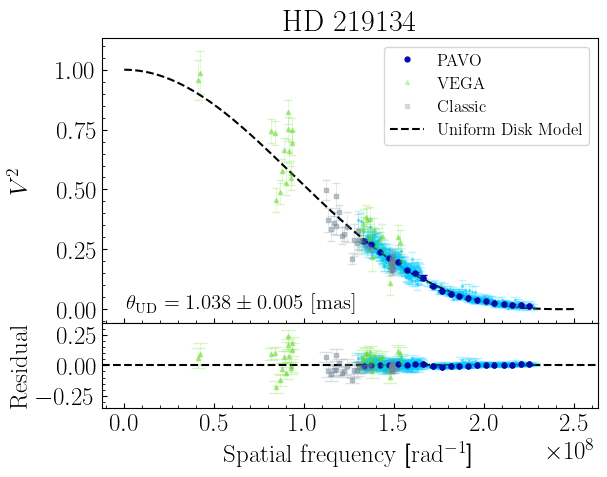

In [40]:
star_names = ['HD 219134']
for star_name in star_name:
    plot_v2_fit(
        data_dict=data_dict,
        star=star,        
        datasets_to_plot=['pavo', 'vega', 'classic'],
        to_bin = ['pavo'],
        plot_udmodel = True,
        title = 'HD~219134',
        eq_text=True,
        show = True
    )

### Example 2: Limb-darkened disk fit
Here I want to plot the limb-darkened disk fit in the 'R' band. I want all three data sets, and I want the PAVO data binned. I also want to annotate the diameter to the plot.

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,       
    line_spf=np.linspace(0.00001, 2.5e8, 1000),
    set_axis = [0, 2.5e8, -0.05,1.1],
    ldc_band='ldc_R',      
    datasets_to_plot=['pavo', 'vega', 'classic'],
    plot_ldmodel = True,
    to_bin = ['pavo'],
    eq_text=True,
    show = True
)

### Example 3:

Here I want to plot the limb-darkened disk fit for the K band and I don't want to annotate the diameter to the plot. I also don't want any data binned.

In [ ]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,         
    line_spf=np.linspace(0.00001, 2.5e8, 1000),
    set_axis = [0, 2.5e8, -0.05,1.1],
    ldc_band='ldc_K',     
    datasets_to_plot=['pavo', 'vega', 'classic'],
    plot_ldmodel = True,
    eq_text=True,
    show = True
)

Here is the full import statement block for all the things needed for this script:

In [ ]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values